## ENDG 511 Project Experiment

This notebook will showcase the project experiment with the intention of expanding on the RODNet implementations to apply concepts learned in the course such as pruning, quantization, and clustering for TinyAI and multibranching architectures for FastAI.

## Import Required Dependencies

In [22]:
# RodNet
from rodnet.core.post_processing import (
    ConfmapStack, 
    post_process, 
    post_process_single_frame, 
    write_dets_results, 
    write_dets_results_single_frame, 
    lnms, 
    ops
)
from rodnet.utils.visualization import (
    visualize_train_img, 
    visualize_test_img_wo_gt, 
    visualize_confmap, 
    visualize_test_img
)
from rodnet.utils.load_configs import (
    load_configs_from_file, 
    parse_cfgs, 
    update_config_dict
)
from rodnet.utils.solve_dir import create_dir_for_new_model
from plots import plot_loss, plot_base_pdf, plot_branch_pdf
from rodnet.datasets.collate_functions import cr_collate
from rodnet.datasets.CRDataset import CRDataset
from cruw import CRUW

# PyTorch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

# General
import numpy as np
import datetime
import os

## Define Project Paths

If you don't prefer to change the following paths below, please visit ReadMe and follow instructions for proper setup of the project directories.

In [2]:
# Date and time of experiment
today = datetime.datetime.now().strftime('%Y-%m-%d--%H:%M:%S').replace(":", "_")
print(f"Time of experiment is: {today}")

Time of experiment is: 2024-03-21--16_48_31


In [3]:
config_fie = os.path.join(os.path.dirname(os.path.realpath('__file__')), "configs/config_rodnet_cdc_win16.py")

# This dataset contains pkl file annotations that were converted.
converted_dataset = os.path.join(os.path.dirname(os.path.realpath('__file__')), "ROD2021/converted_new")

# This is the path to store the trained model weights in a pkl file. If this does not exist, this will be created.
train_model_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), f"checkpoints/{today}")

# This is the path to store the model results, along with the history (JSON), config (JSON) and the plots (images).
test_res_dir = os.path.join(os.path.dirname(os.path.realpath('__file__')), f"results/{today}")

## Define Parameters

In [4]:
# This is by default.
sensor_config_name = "sensor_config_rod2021"
noise_channel = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


## Load Project Paths

In [5]:
if not os.path.exists(config_fie):
    raise FileNotFoundError(f"The configuration file does not exist at {config_fie}")
config_dict = load_configs_from_file(config_fie)

if not os.path.exists(config_dict["dataset_cfg"]["base_root"]):
    path = config_dict['dataset_cfg']['base_root']
    raise FileNotFoundError(f"The configuration path does not exist: {path}")

if not os.path.exists(config_dict["dataset_cfg"]["data_root"]):
    path = config_dict['dataset_cfg']['data_root']
    raise FileNotFoundError(f"The configuration path does not exist: {path}")

if not os.path.exists(config_dict["dataset_cfg"]["anno_root"]):
    path = config_dict['dataset_cfg']['anno_root']
    raise FileNotFoundError(f"The configuration path does not exist: {path}")

model_cfg = config_dict['model_cfg']

if not os.path.exists(train_model_path):
    os.makedirs(train_model_path)

if not os.path.exists(test_res_dir):
    os.makedirs(test_res_dir)

## Load Dataset

In [6]:
dataset = CRUW(data_root=config_dict['dataset_cfg']['base_root'], 
               sensor_config_name=sensor_config_name)
radar_configs = dataset.sensor_cfg.radar_cfg
range_grid = dataset.range_grid         
angle_grid = dataset.angle_grid  

crdata_train = CRDataset(
    data_dir=converted_dataset, 
    dataset=dataset, 
    config_dict=config_dict,
    split='train',
    noise_channel=noise_channel
)
print(f"The total dataset samples: {len(crdata_train)}")

n_class = dataset.object_cfg.n_class          
n_epoch = config_dict['train_cfg']['n_epoch']   
batch_size = config_dict['train_cfg']['batch_size'] 
lr = config_dict['train_cfg']['lr']
train_configs = config_dict['train_cfg']
test_configs = config_dict['test_cfg']
win_size = train_configs['win_size']

100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

The total dataset samples: 3058


### Split Dataset into Train and Validation

In [7]:
# This is a random split, so ensure models are trained and evaluated in one session to have 1 to 1 comparison.
train_data, validation_data = torch.utils.data.random_split(crdata_train,[2358,700])

print(f"{len(train_data)=}")
print(f"{len(validation_data)=}")

len(train_data)=2358
len(validation_data)=700


### Define Dataset Loaders

In [8]:
tdataloader = DataLoader(
    train_data, 
    batch_size, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=cr_collate)
vdataloader = DataLoader(
    validation_data, 
    batch_size=1, 
    shuffle=True, 
    num_workers=0, 
    collate_fn=cr_collate)

## Import Model Dependencies

In [9]:
import importlib
import getModel
importlib.reload(getModel)
from getModel import RODNetBase, RODNetBranched
import trainModel
importlib.reload(trainModel)
from trainModel import TrainBranchedHandler, TrainBaseHandler
import validateModel
importlib.reload(validateModel)
from validateModel import ValidateBranchedHandler, ValidateBaseHandler

## Load Base Model

In [10]:
rodnet_base = RODNetBase(in_channels=2, n_class=n_class).to(device)
base_optimizer = optim.Adam(rodnet_base.parameters(), lr=lr, eps=1e-4)
base_criterion = nn.BCEWithLogitsLoss()
base_scheduler = StepLR(base_optimizer, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

base_trainer = TrainBaseHandler(
    rodnet_base,
    base_criterion,
    base_optimizer,
    device,
    base_scheduler,
    n_epoch
)

In [11]:
rodnet_base.print_summary()
rodnet_base.print_size_of_model()

Number of encoder parameters: 28601088
Number of decoder long parameters: 5919172
Size (KB): 138101.54


### Load F16 Quantized Base Model

In [12]:
from copy import deepcopy
# Base Float32 -> Float16 Quantization
# Check layer type
print("Checking base model layer type...")
# Note change to -1 to view full layer types.
rodnet_base.print_parameter_type(cutoff=1)
rodnet_base_f16 = deepcopy(rodnet_base).half()

# Avoid convergence issues
for layer in rodnet_base_f16.modules():
  if isinstance(layer, nn.BatchNorm3d):
    layer.float()

  for child in layer.children():
    if isinstance(child, nn.BatchNorm3d):
        child.float()

print("\nChecking quantized base model layer type...")
# Note change to -1 to view full layer types.
rodnet_base_f16.print_parameter_type(cutoff=1)
rodnet_base_f16.print_size_of_model()
print("\nVerifying number of parameters did not change...")
rodnet_base_f16.print_summary()

# Use a smaller eps because half precision will round it to 0, resulting in values of NaN for the loss.
f16_quantized_base_optimizer = optim.Adam(rodnet_base_f16.parameters(), lr=lr, eps=1e-4) 
f16_quantized_base_criterion = nn.BCEWithLogitsLoss()
f16_quantized_base_scheduler = StepLR(f16_quantized_base_optimizer, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

f16_quantized_base_trainer = TrainBaseHandler(
    rodnet_base_f16,
    f16_quantized_base_criterion,
    f16_quantized_base_optimizer,
    device,
    f16_quantized_base_scheduler,
    n_epoch,
    half=True
)

Checking base model layer type...
encoder.conv1a.weight :  torch.float32
encoder.conv1a.bias :  torch.float32

Checking quantized base model layer type...
encoder.conv1a.weight :  torch.float16
encoder.conv1a.bias :  torch.float16
Size (KB): 69064.548

Verifying number of parameters did not change...
Number of encoder parameters: 28601088
Number of decoder long parameters: 5919172


### Load Int8 Quantized Base Model

In [ ]:
# TODO: Implement

## Load Branched Model

In [ ]:
rodnet_branched = RODNetBranched(in_channels=2, n_class=n_class).to(device)
branched_optimizer = optim.Adam(rodnet_branched.parameters(), lr=lr, eps=1e-4)
branched_criterion = nn.BCEWithLogitsLoss()
branched_scheduler = StepLR(branched_optimizer, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

branched_trainer = TrainBranchedHandler(
    rodnet_branched,
    branched_criterion,
    branched_optimizer,
    device,
    branched_scheduler,
    n_epoch
)

In [ ]:
rodnet_branched.print_summary()
rodnet_branched.print_size_of_model()

### Load F16 Quantized Branched Model

In [ ]:
from copy import deepcopy
# Base Float32 -> Float16 Quantization
# Check layer type
print("Checking branched model layer type...")
# Note change to -1 to view full layer types.
rodnet_branched.print_parameter_type(cutoff=1)
rodnet_branched_f16 = deepcopy(rodnet_branched).half()

# Avoid convergence issues
for layer in rodnet_branched_f16.modules():
  if isinstance(layer, nn.BatchNorm3d):
    layer.float()

  for child in layer.children():
    if isinstance(child, nn.BatchNorm3d):
        child.float()

print("\nChecking quantized branch model layer type...")
# Note change to -1 to view full layer types.
rodnet_branched_f16.print_parameter_type(cutoff=1)
rodnet_branched_f16.print_size_of_model()
print("\nVerifying number of parameters did not change...")
rodnet_branched_f16.print_summary()

# Use a smaller eps because half precision will round it to 0, resulting in values of NaN for the loss.
f16_quantized_branched_optimizer = optim.Adam(rodnet_branched_f16.parameters(), lr=lr, eps=1e-4) 
f16_quantized_branched_criterion = nn.BCEWithLogitsLoss()
f16_quantized_branched_scheduler = StepLR(f16_quantized_branched_optimizer, step_size=config_dict['train_cfg']['lr_step'], gamma=0.1)

f16_quantized_branched_trainer = TrainBaseHandler(
    rodnet_branched_f16,
    f16_quantized_branched_criterion,
    f16_quantized_branched_optimizer,
    device,
    f16_quantized_branched_scheduler,
    n_epoch,
    half=True
)

### Load Int8 Quantized Branched Model

In [ ]:
# TODO: Implement

## Load Prune Model

In [ ]:
# TODO: Implement

## Load Clustering Model

In [ ]:
# TODO: Implement

## Train and Evaluate Base Model

In [13]:
test_res_dir_base = os.path.join(test_res_dir, "base")
if not os.path.exists(test_res_dir_base):
    os.makedirs(test_res_dir_base)

train_model_path_base = os.path.join(train_model_path, "base")
if not os.path.exists(train_model_path_base):
    os.makedirs(train_model_path_base)

In [14]:
trained_rodnet_base, history_base = base_trainer.train(tdataloader, train_model_path_base)
base_trainer.save_metrics(test_res_dir_base)

epoch 1 --> trainLoss: 0.837
saving current epoch model ...
epoch 2 --> trainLoss: 0.696
saving current epoch model ...
epoch 3 --> trainLoss: 0.694
saving current epoch model ...
epoch 4 --> trainLoss: 0.694
saving current epoch model ...
epoch 5 --> trainLoss: 0.693
saving current epoch model ...


In [15]:
print(f"Base Model Loss: {history_base['train']['loss']}")

# TODO: Report Precision, Recall, Accuracy

Base Model Loss: [0.8370231342517723, 0.6962193781036442, 0.6941373058294846, 0.6936829993280313, 0.6934934628211846]


### Plot Loss

C:\Users\john.s\AppData\Local\Temp\ipykernel_12032\3461239881.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


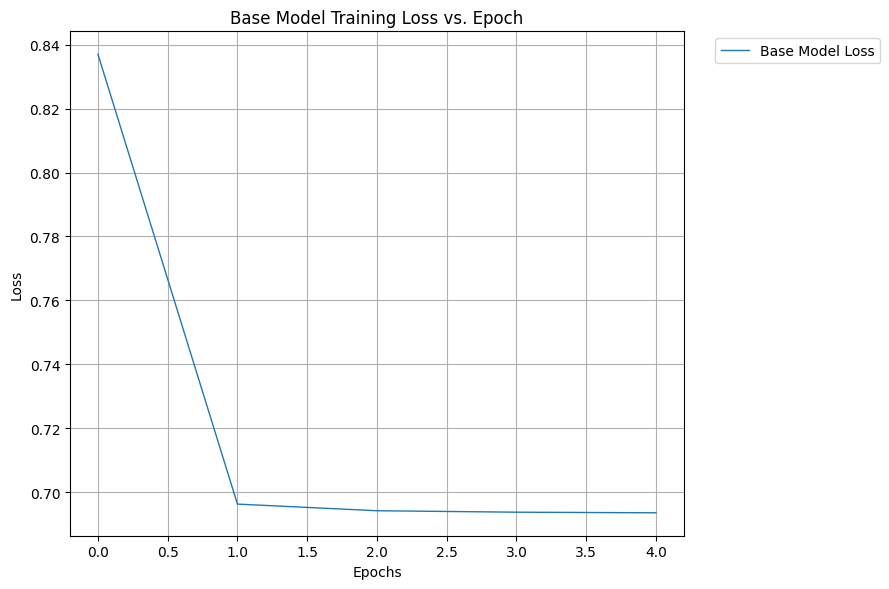

In [25]:
total_loss = history_base['train']['loss']
epochs = list(range(n_epoch))

fig = plot_loss("Base Model", epochs, [total_loss], ["Base Model"]) # NOSONAR
fig.savefig(os.path.join(test_res_dir_base, "base_loss.png"))
fig.show()

### Evaluate Model

In [35]:
base_model = RODNetBase(in_channels=2, n_class=n_class).to(device)
base_model.load_state_dict(torch.load(
    os.path.join(train_model_path_base,'base_epoch_0{}_final.pkl'.format(n_epoch))))
base_model.eval()

base_validator = ValidateBaseHandler(
    base_model,
    dataset,
    config_dict, 
    base_criterion,
    device
)

In [38]:
base_validator.validate(vdataloader, test_res_dir_base)
base_validator.save_metrics(test_res_dir_base)

### Plot PDF

C:\Users\john.s\AppData\Local\Temp\ipykernel_12032\4147640842.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


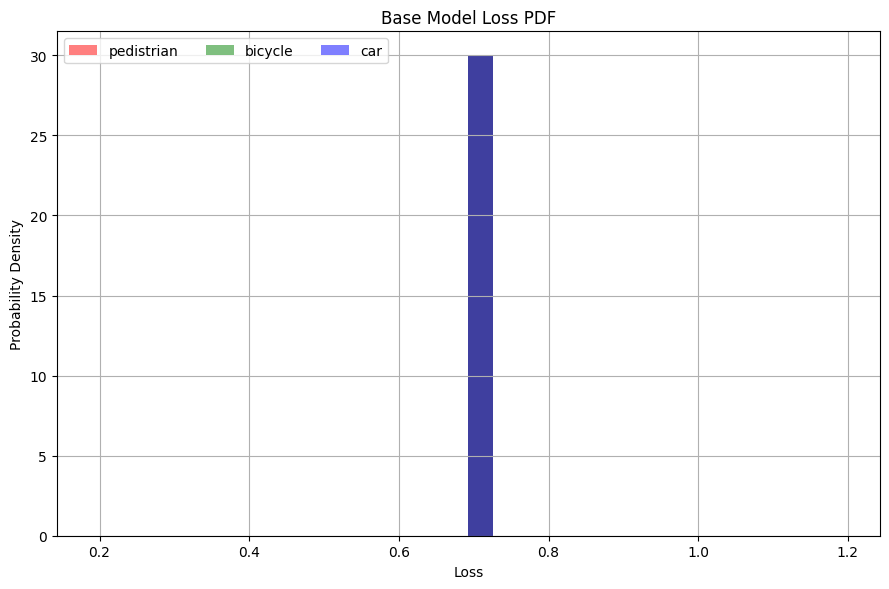

In [41]:
fig = plot_base_pdf("Base Model", base_validator.metrics)
fig.savefig(os.path.join(test_res_dir_base, "base_pdf.png"))
fig.show()

## Train and Evaluate Base F16 Quantized Model

In [42]:
test_res_dir_base_f16_quantized = os.path.join(test_res_dir, "base_quantized_f16")
if not os.path.exists(test_res_dir_base_f16_quantized):
    os.makedirs(test_res_dir_base_f16_quantized)

train_model_path_base_f16_quantized = os.path.join(train_model_path, "base_quantized_f16")
if not os.path.exists(train_model_path_base_f16_quantized):
    os.makedirs(train_model_path_base_f16_quantized)

In [43]:
trained_rodnet_base_quantized_f16, history_base_quantized_f16 = f16_quantized_base_trainer.train(tdataloader, train_model_path_base_f16_quantized)
f16_quantized_base_trainer.save_metrics(test_res_dir_base_f16_quantized)

In [ ]:
print(f"F16 Quantized Base Model Loss: {history_base_quantized_f16['train']['loss']}")

# TODO: Report Precision, Recall, Accuracy

### Plot Loss

In [ ]:
total_loss = history_base_quantized_f16['train']['loss']
epochs = list(range(n_epoch))

fig = plot_loss("F16 Quantized Base Model", epochs, [total_loss], ["F16 Quantized Base Model"])
fig.savefig(os.path.join(test_res_dir_base_f16_quantized, "f16_quantized_base_loss.png"))
fig.show()

### Evaluate Model

In [ ]:
f16_quantized_base_model = RODNetBase(in_channels=2, n_class=n_class).to(device)
f16_quantized_base_model.half()

# Avoid convergence issues
for layer in f16_quantized_base_model.modules():
  if isinstance(layer, nn.BatchNorm3d):
    layer.float()

  for child in layer.children():
    if isinstance(child, nn.BatchNorm3d):
        child.float()

f16_quantized_base_model.load_state_dict(torch.load(
    os.path.join(train_model_path_base_f16_quantized,'base_epoch_0{}_final.pkl'.format(n_epoch))))
f16_quantized_base_model.eval()

f16_quantized_base_validator = ValidateBaseHandler(
    f16_quantized_base_model,
    dataset,
    config_dict, 
    f16_quantized_base_criterion,
    device
)

In [ ]:
f16_quantized_base_validator.validate(vdataloader, test_res_dir_base_f16_quantized)
f16_quantized_base_validator.save_metrics(test_res_dir_base_f16_quantized)

### Plot PDF

In [ ]:
fig = plot_base_pdf("F16 Quantized Base Model", f16_quantized_base_validator.metrics)
fig.savefig(os.path.join(test_res_dir_base_f16_quantized, "f16_quantized_base_pdf.png"))
fig.show()

## Train and Evaluate Multibranch Model

In [ ]:
test_res_dir_branched = os.path.join(test_res_dir, "branched")
if not os.path.exists(test_res_dir_branched):
    os.makedirs(test_res_dir_branched)

train_model_path_branched = os.path.join(train_model_path, "branched")
if not os.path.exists(train_model_path_branched):
    os.makedirs(train_model_path_branched)

In [ ]:
trained_rodnet_branched, history_branched = branched_trainer.train(tdataloader, train_model_path_branched)
branched_trainer.save_metrics(test_res_dir_branched)

In [ ]:
print(f"Branched Model Total Loss: {history_branched['total']['train']['loss']}")

# TODO: Report Precision, Recall, Accuracy

### Plot Loss

In [ ]:
total_loss = history_branched['total']['train']['loss']
short_branch_loss = history_branched['short_branched']['train']['loss']
long_branch_loss = history_branched['long_branched']['train']['loss']
epochs = list(range(n_epoch))

fig = plot_loss(
    "Multibranch Model", 
    epochs, 
    [total_loss, short_branch_loss, long_branch_loss], 
    ["Total", "Short Branch", "Long Branch"]
)
fig.savefig(os.path.join(test_res_dir_branched, "branch_loss.png"))
fig.show()

### Evaluate Model

In [ ]:
branched_model = RODNetBranched(in_channels=2, n_class=n_class).to(device)
branched_model.load_state_dict(torch.load(
    os.path.join(train_model_path_branched,'multi_epoch_0{}_final.pkl'.format(n_epoch))))
branched_model.eval()

branched_validator = ValidateBranchedHandler(
    branched_model,
    dataset,
    config_dict, 
    branched_criterion,
    device
)

In [ ]:
branched_validator.validate(vdataloader, test_res_dir_branched)
branched_validator.save_metrics(test_res_dir_branched)

### Plot PDF

In [ ]:
fig = plot_branch_pdf("Branch Model", branched_validator.metrics)
fig.savefig(os.path.join(test_res_dir_branched, "branch_pdf.png"))
fig.show()

## Train and Evaluate Multibranch F16 Quantized Model

In [ ]:
test_res_dir_branched_f16 = os.path.join(test_res_dir, "branched_quantized_f16")
if not os.path.exists(test_res_dir_branched_f16):
    os.makedirs(test_res_dir_branched_f16)

train_model_path_branched_f16 = os.path.join(train_model_path, "branched_quantized_f16")
if not os.path.exists(train_model_path_branched_f16):
    os.makedirs(train_model_path_branched_f16)

In [ ]:
trained_rodnet_branched_f16, history_branched_f16 = f16_quantized_branched_trainer.train(tdataloader, train_model_path_branched_f16)
f16_quantized_branched_trainer.save_metrics(test_res_dir_branched_f16)

In [ ]:
print(f"F16 Quantized Branched Model Total Loss: {history_branched_f16['total']['train']['loss']}")

# TODO: Report Precision, Recall, Accuracy

### Plot Loss

In [ ]:
total_loss = history_branched_f16['total']['train']['loss']
short_branch_loss = history_branched_f16['short_branched']['train']['loss']
long_branch_loss = history_branched_f16['long_branched']['train']['loss']
epochs = list(range(n_epoch))

fig = plot_loss(
    "F16 Quantized Multibranch Model", 
    epochs, 
    [total_loss, short_branch_loss, long_branch_loss], 
    ["Total", "Short Branch", "Long Branch"]
)
fig.savefig(os.path.join(test_res_dir_branched_f16, "f16_quantized_branch_loss.png"))
fig.show()

### Evaluate Model

In [ ]:
f16_quantized_branched_model = RODNetBranched(in_channels=2, n_class=n_class).to(device)
f16_quantized_branched_model.half()

# Avoid convergence issues
for layer in f16_quantized_branched_model.modules():
  if isinstance(layer, nn.BatchNorm3d):
    layer.float()

  for child in layer.children():
    if isinstance(child, nn.BatchNorm3d):
        child.float()

f16_quantized_branched_model.load_state_dict(torch.load(
    os.path.join(train_model_path_branched_f16,'multi_epoch_0{}_final.pkl'.format(n_epoch))))
f16_quantized_branched_model.eval()

f16_quantized_branched_validator = ValidateBranchedHandler(
    f16_quantized_branched_model,
    dataset,
    config_dict, 
    f16_quantized_branched_criterion,
    device
)

In [ ]:
f16_quantized_branched_validator.validate(vdataloader, test_res_dir_branched_f16)
f16_quantized_base_validator.save_metrics(test_res_dir_branched_f16)

### Plot PDF

In [ ]:
fig = plot_branch_pdf("F16 Quantized Branch Model", f16_quantized_branched_validator.metrics)
fig.savefig(os.path.join(test_res_dir_branched_f16, "f16_quantized_branch_pdf.png"))
fig.show()